In [1]:
#########################
#KZIHT+KZPT for Tensors##
#########################

##########################
### Analysing Error ######
##########################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import rand, randn, choice, permutation
from scipy.linalg import hadamard

import torch
import torch.nn.functional as F

import tensorly as tl
from tensorly import decomposition
from tensorly.decomposition import parafac

In [2]:
## Defining Measurement Matrices ##

def gaussian_mx(m,N):
    A = np.random.normal(0.0, 1.0, [m, N])
    return A

def hadamard_mx(m,N):
    A = hadamard(N)
    l = permutation(np.range(N))
    return A[l[:m],:]

def SJLT_mx(m,N,sp):    
    delta = np.zeros((sp,N))
    matrix = np.zeros((m,N))
    sigma = np.zeros((m,N))
    
    for i in range(sp): 
        for j in range(N): 
            delta[i, j] = np.random.randint(2) * 2 - 1
    
    for i in range(N):
        sparse_col = np.random.choice(m, sp, replace=False)
        matrix[sparse_col,i] = delta[:,i]
        
    return matrix

In [3]:
## Tensor Helper Functions ########

def vectorize_tl(X): ##Vectorisation for tensors
    x=X.numpy()
    x=x.reshape(-1)
    return x

def vectorize_np(X):  ##Vecorisation for numpy arrays
    x=X
    x=x.reshape(-1)
    return x

In [4]:
## Thresholding operators #########

def sparse_vect(x,s): ## s-sparse approximation
    
    x_1 = np.abs(x)
    index = np.flip(np.argsort(x_1))[:s]
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]

    return l

def sparse_vect_random(x,s):
    
    index = np.random.choice(np.shape(x)[0], s, replace=False)
    l = np.zeros(np.shape(x)[0])
    l[index] = x[index]
    
    return l

def random_low_rank_HOSVD(n,r):
    C=np.random.normal(0,1,size=r)
    C=tl.tensor(C)
    C.shape
    X=C

    U=[]
    for i in range(len(n)):
        M=np.random.normal(0,1,size=(n[i],n[i]))
        u,sigma,v=np.linalg.svd(M)
        U.append(u[:,0:r[i]])

    for i in range(len(n)):
        X=tl.tenalg.mode_dot(X,U[i],i)
    return X

def random_low_rank_CP(n,r):   #### CP Rank r
    #torch.manual_seed(0)
    #np.random.seed(0)
    
    L = []
    for i in range(0,len(n)):
        C=np.random.normal(0,1,size=(n[i],r))
        L = L + [C]
    
    X = np.zeros(n)
    for i in range(r):
        U_r = np.array(L[0])[:,i]
        for j in range(1, len(n)):
            prod = np.array(L[j])[:,i]
            U_r = np.multiply.outer(U_r,prod)
        X = X + U_r
        
    C=tl.tensor(X) #Changing data frame to tensor
    C.shape
    return C

def HOSVD_rank_app(tensor,r): ## HOSVD rank-r approximation
    
    core, factors = tl.decomposition.tucker(tensor.numpy(), r) #Decomposition function is used 
    answer = torch.tensor(tl.tucker_to_tensor([core, factors]))
    
    return answer

def CP_rank_app(tensor,r):  ## CP rank-r approximation
    
    factors = parafac(tl.tensor(tensor), rank=r)
    answer = tl.cp_to_tensor(factors)
    
    return answer

In [5]:
def IHT(A,b,x,s,lamda=1,itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y= np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates

        y = y + lamda*np.matmul(A.T, (b - np.matmul(A,y)))
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error

In [6]:
def TIHT_CP(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n) ##Random Initialisation

    for j in range(itr):
    
        WW = np.array(vectorize_np(vXX)) + lamda*np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_np(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = CP_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_np(vXX)- X_ravel)
        
    return vXX, error

In [140]:
def TIHT_HOSVD(AA,yy,X,r,lamda = 1, itr = 100): 
    
    n = np.shape(X)
    X_ravel = np.ravel(X)
    
    error = np.zeros(itr)
    
    vXX = torch.randn(n) ##Random Initialisation

    for j in range(itr):
    
        WW = np.array(vectorize_tl(vXX)) + lamda* np.matmul(AA.T, (yy - np.matmul(AA, np.array(vectorize_tl(vXX)))))
        WW = torch.reshape(torch.tensor(WW), n)
        vXX = HOSVD_rank_app(WW,r)
        error[j] = np.linalg.norm(vectorize_tl(vXX)- X_ravel)
        
    return vXX, error

In [7]:
## Standard Kaczmarz Algorithm run for 100 iterations where rows are sampled with replacement

def KZ(A,b,x,itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y = np.zeros(np.shape(x)[0]) #Initialisation
    
    for i in range(itr):
        error[i] = np.linalg.norm(y-x)
        t = np.random.randint(m)
        a = A[t,:]
        y = y + (b[t] - a@y)*(a/np.linalg.norm(a)**2)
        error[i] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error
                

In [9]:
def KZIHT(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y = np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
                             
    return y,error
                           

In [10]:
# Qn: Choosing without replacement makes sense without a period? Otherwise we just end up picking all m?
# Randomly cycle through them!!!! Better than just cycling in order cause updates depend on one another

def KZIHT_RR(A,b,x,s,gamma=1,itr=100): ## Selecting rows with replacement, gamma-step size for Kaczmarz
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    y= np.zeros(np.shape(x)[0])
    
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                           
        y = sparse_vect(y,s)
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
        
    return y,error

In [11]:
def KZIHT_CP(A,b,X,n,r,gamma = 1, itr = 100): ## n denotes dimensions of the tensor
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])  
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_np(CP_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [12]:
def KZIHT_HOSVD(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
    
    for k in range(itr): # Outer iteration for IHT updates
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            t = np.random.randint(m)
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [17]:
def KZIHT_HOSVD_RR(A,b,X,n,r,gamma = 1, itr = 100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])    
            
    for k in range(itr): # Outer iteration for IHT updates
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                                     
        WW = torch.reshape(torch.tensor(y), n)
        y = vectorize_tl(HOSVD_rank_app(WW,r))
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
                             
    return y,error

In [13]:
def KZPT(A,b,x,s,p,gamma=1,lamda = 1,itr=100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    m_1 = int(m/p)
    y = np.zeros(np.shape(x)[0])
    y_1 = np.zeros(np.shape(x)[0])
    
    for k in range(itr): 
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            if j == 0:
                y_1 = y
                
                
            t = np.random.randint(m)    
            a = A[t,:]
            y = y + gamma*(b[t] - a@y)*a/(np.linalg.norm(a)**2)
                           
            if j%p == 0:
                y_2 = y_1 + lamda*(y - y_1)
                y = sparse_vect(y_2,s)          
            
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
        
    return y,error

In [14]:
### Both gamma and lambda are tunable parameters 

def KZPT_RR(A,b,x,s,p,gamma=1,lamda = 1,itr=100):
    
    error = np.zeros(itr)
    m = np.shape(A)[0]
    m_1 = int(m/p)
    y = np.zeros(np.shape(x)[0])
    y_1 = np.zeros(np.shape(x)[0])
    
    for k in range(itr): 
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            if j == 0:
                y_1 = y
                
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                           
            if j%p == 0:
                y_2 = y_1 + lamda*(y - y_1)
                y = sparse_vect(y_2,s)          
            
        error[k] = np.linalg.norm(y-x)/np.linalg.norm(x)
        
    return y,error

In [15]:
def KZPT_RR_CP(A,b,X,r,n,p,gamma=1,lamda = 1,itr=100):
    
    error = np.zeros(itr)
    
    m = np.shape(A)[0]
    m_1 = int(m/p)
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])
    y_1 = np.zeros(np.shape(x)[0])
    
    for k in range(itr): 
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            if j == 0:
                y_1 = y
                
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                           
            if j%p == 0:
                y_2 = y_1 + lamda*(y - y_1)
                WW = torch.reshape(torch.tensor(y_2), n)
                y = vectorize_np(CP_rank_app(WW,r))
                
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
        
    return y,error

In [16]:
def KZPT_RR_HOSVD(A,b,X,r,n,p,gamma=1,lamda = 1,itr=100):
    
    error = np.zeros(itr)
    
    m = np.shape(A)[0]
    m_1 = int(m/p)
    
    n = np.shape(X)
    x = np.ravel(X)
    
    y = np.zeros(np.shape(x)[0])
    y_1 = np.zeros(np.shape(x)[0])
    
    for k in range(itr): 
        
        t = permutation(np.arange(m))
        
        for j in range(m): #Inner iteration for Kaczmarz updates
            
            if j == 0:
                y_1 = y
                
            a = A[t[j],:]
            y = y + gamma*(b[t[j]] - a@y)*a/(np.linalg.norm(a)**2)
                           
            if j%p == 0:
                y_2 = y_1 + lamda*(y - y_1)
                WW = torch.reshape(torch.tensor(y_2), n)
                y = vectorize_tl(HOSVD_rank_app(WW,r))   
                
        error[k] = np.linalg.norm(vectorize_np(y)-x)/np.linalg.norm(x)
        
    return y,error

In [18]:
######### Sanity Check: Sparse Vector Recovery ######
## Errorless Recovery
## Gaussian Matrices

cols = []
data = []
itr = 250
num_samples = 50
j = 0

for s in [5,10,20,50,100,150,200,250]:
    
    avg_err_IHT = np.zeros(itr)
    avg_err_KZIHT = np.zeros(itr)
    cols = cols + ['iht'+str(s), 'kziht'+str(s)]
    
    #print(s)
        
    for samples in range(num_samples):
        
        #print(samples)
        
        n = 1000
        m = 800

        x = np.random.normal(0.0,1.0,n)
        x = sparse_vect_random(x,s)

        A = gaussian_mx(800,1000)
        b = A@x 
        
        y_IHT,error_IHT = IHT(A,b,x,s,lamda=1/m,itr = itr)
        y_KZIHT, error_KZIHT = KZIHT(A,b,x,s,gamma=(n/m),itr = itr)
        
        avg_err_IHT = avg_err_IHT + error_IHT
        avg_err_KZIHT = avg_err_KZIHT + error_KZIHT
        
    if j == 0:
        
        data = np.concatenate(([avg_err_IHT/num_samples],[avg_err_KZIHT/num_samples]), axis = 0).T
        j = j + 1
    
    else:
        
        data = np.concatenate((data, np.array([avg_err_IHT/num_samples]).T),axis=1)
        data = np.concatenate((data, np.array([avg_err_KZIHT/num_samples]).T),axis=1) 

data = pd.DataFrame(data, columns = cols)
data.to_csv("sparse_vect.csv", header = True)

KeyboardInterrupt: 

In [113]:
######### Sanity Check: Sparse Vector Recovery ######
## Errorless Recovery
## SJLT

cols = []
data = []
itr = 250
num_samples = 50
j = 0

for s in [5,10,20,50,100,150,200]:
    
    avg_err_IHT = np.zeros(itr)
    avg_err_KZIHT = np.zeros(itr)
    cols = cols + ['iht'+str(s), 'kziht'+str(s)]
    
    print(s)
        
    for samples in range(num_samples):
        
        #print(samples)
        
        n = 1000
        m = 800
        sp = 600

        x = np.random.normal(0.0,1.0,n)
        x = sparse_vect_random(x,s)
        b = A@x 
        
        y_IHT,error_IHT = IHT(A,b,x,s,lamda=1/sp,itr = itr)
        y_KZIHT, error_KZIHT = KZIHT(A,b,x,s,gamma=(n/sp),itr = itr)
        
        avg_err_IHT = avg_err_IHT + error_IHT
        avg_err_KZIHT = avg_err_KZIHT + error_KZIHT
        
    if j == 0:
        
        data = np.concatenate(([avg_err_IHT/num_samples],[avg_err_KZIHT/num_samples]), axis = 0).T
        j = j + 1
    
    else:
        
        data = np.concatenate((data, np.array([avg_err_IHT/num_samples]).T),axis=1)
        data = np.concatenate((data, np.array([avg_err_KZIHT/num_samples]).T),axis=1) 

data = pd.DataFrame(data, columns = cols)
data.to_csv("sparse_vect_SJLT.csv", header = True)

5
10
20
50
100
150
200


In [114]:
######### Sanity Check: Sparse Vector Recovery ######
## Errorless Recovery
## Gaussian Matrices

cols = []
data = []
itr = 250
num_samples = 5
j = 0
p = 80

for s in [50,100,150,200,250]:
    
    avg_err_IHT = np.zeros(itr)
    avg_err_KZPT = np.zeros(itr)
    cols = cols + ['iht'+str(s), 'kziht'+str(s)]
    
    print(s)
        
    for samples in range(num_samples):
        
        #print(samples)
        
        n = 1000
        m = 400

        x = np.random.normal(0.0,1.0,n)
        x = sparse_vect_random(x,s)

        A = gaussian_mx(m,n)
        b = A@x 
        
        y_IHT,error_IHT = IHT(A,b,x,s,lamda=1/m,itr = itr)
        y_KZPT, error_KZPT = KZPT(A,b,x,s,p,gamma=n/m,lamda = 1,itr=itr)
        
        avg_err_IHT = avg_err_IHT + error_IHT
        avg_err_KZPT = avg_err_KZPT + error_KZPT
        
    if j == 0:
        
        data = np.concatenate(([avg_err_IHT/num_samples],[avg_err_KZPT/num_samples]), axis = 0).T
        j = j + 1
    
    else:
        
        data = np.concatenate((data, np.array([avg_err_IHT/num_samples]).T),axis=1)
        data = np.concatenate((data, np.array([avg_err_KZPT/num_samples]).T),axis=1) 

data = pd.DataFrame(data, columns = cols)
data.to_csv("sparse_vect_kzpt.csv", header = True)

50
100
150
200
250


In [150]:
###################################
### Recovering Tensors via KZIHT ##
## Low HOSVD Rank #################
###################################

## Considering 10*10*10 tensors
## Errorless Recovery
## Gaussian Measurement Matrices 

cols = []
data = []

itr = 250
num_samples = 50
j = 0

n = 1000
n_dim = [10,10,10]
m = 800

for r in [[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5]]:
    
    avg_err_IHT = np.zeros(itr)
    avg_err_KZIHT = np.zeros(itr)
    cols = cols + ['iht'+str(r[0]), 'kziht'+str(r[0])]
    
    print(r)
        
    for samples in range(num_samples):
        
        #print(samples)
        
        X = random_low_rank_HOSVD(n_dim,r)
        x = vectorize_np(X)

        A = gaussian_mx(m,n)
        b = A@x 
        
        y_IHT,error_IHT = TIHT_HOSVD(A,b,X,r,lamda=1/m,itr = itr)
        y_KZIHT, error_KZIHT = KZIHT_HOSVD(A,b,X,n,r,gamma = n/m, itr = itr)
        
        avg_err_IHT = avg_err_IHT + error_IHT
        avg_err_KZIHT = avg_err_KZIHT + error_KZIHT
        
    if j == 0:
        
        data = np.concatenate(([avg_err_IHT/num_samples],[avg_err_KZIHT/num_samples]), axis = 0).T
        j = j + 1
    
    else:
        
        data = np.concatenate((data, np.array([avg_err_IHT/num_samples]).T),axis=1)
        data = np.concatenate((data, np.array([avg_err_KZIHT/num_samples]).T),axis=1) 

data = pd.DataFrame(data, columns = cols)
data.to_csv('/Users/shambhavi/Desktop/Academic/KZ+IHT/Code/sparse_tens_kiht.csv', header = True)

[1, 1, 1]
[2, 2, 2]
[3, 3, 3]
[4, 4, 4]
[5, 5, 5]


In [151]:
data_1 = pd.read_csv('/Users/shambhavi/Desktop/Academic/KZ+IHT/Code/sparse_tens_kiht.csv')
data_1 = np.array(data_1.drop(data_1.columns[0],axis = 1))

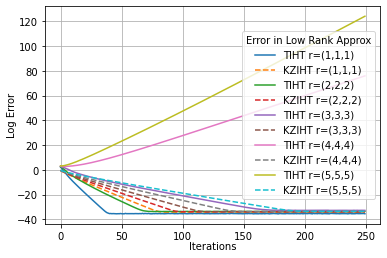

In [152]:
plt.figure()
plt.title("", pad = 30, loc = "center")

plt.plot(range(itr), np.log(data_1[:,0]),  label= "TIHT r=(1,1,1)")
plt.plot(range(itr), np.log(data_1[:,1]),label= "KZIHT r=(1,1,1)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,2]),  label= "TIHT r=(2,2,2)")
plt.plot(range(itr), np.log(data_1[:,3]),label= "KZIHT r=(2,2,2)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,4]),  label= "TIHT r=(3,3,3)")
plt.plot(range(itr), np.log(data_1[:,5]),label= "KZIHT r=(3,3,3)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,6]),  label= "TIHT r=(4,4,4)")
plt.plot(range(itr), np.log(data_1[:,7]),label= "KZIHT r=(4,4,4)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,8]),  label= "TIHT r=(5,5,5)")
plt.plot(range(itr), np.log(data_1[:,9]),label= "KZIHT r=(5,5,5)",linestyle = '--')

plt.legend(title="Error in Low Rank Approx")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Log Error",labelpad = 0)
plt.grid()
plt.savefig('KZIHT VS. TIHT.png', dpi=300,  bbox_inches="tight")

In [167]:
###################################
### Recovering Tensors via KZIHT ##
##### Low CP Rank #################
###################################

## Considering 10*10*10 tensors
## Errorless Recovery
## Gaussian Measurement Matrices 

cols = []
data = []

itr = 250
num_samples = 50
j = 0

n = 1000
n_dim = [10,10,10]
m = 800

for r in [2,3,4,5]:
    
    avg_err_IHT = np.zeros(itr)
    avg_err_KZIHT = np.zeros(itr)
    cols = cols + ['iht'+str(r), 'kziht'+str(r)]
    
    print(r)
        
    for samples in range(num_samples):
        
        #print(samples)
        
        X = random_low_rank_CP(n_dim,r)
        x = vectorize_np(X)

        A = gaussian_mx(m,n)
        b = A@x 
        
        y_IHT,error_IHT = TIHT_CP(A,b,X,r,lamda=1/m,itr = itr)
        y_KZIHT, error_KZIHT = KZIHT_CP(A,b,X,n,r,gamma = n/m, itr = itr)
        
        avg_err_IHT = avg_err_IHT + error_IHT
        avg_err_KZIHT = avg_err_KZIHT + error_KZIHT
        
    if j == 0:
        
        data = np.concatenate(([avg_err_IHT/num_samples],[avg_err_KZIHT/num_samples]), axis = 0).T
        j = j + 1
    
    else:
        
        data = np.concatenate((data, np.array([avg_err_IHT/num_samples]).T),axis=1)
        data = np.concatenate((data, np.array([avg_err_KZIHT/num_samples]).T),axis=1) 

data = pd.DataFrame(data, columns = cols)
data.to_csv('/Users/shambhavi/Desktop/Academic/KZ+IHT/Code/sparse_tens_kiht_CP.csv', header = True)

2
3
4
5


In [168]:
data_1 = pd.read_csv('/Users/shambhavi/Desktop/Academic/KZ+IHT/Code/sparse_tens_kiht_CP.csv')
data_1 = np.array(data_1.drop(data_1.columns[0],axis = 1))

In [169]:
data_1

array([[1.46903389e+01, 5.73043629e-01, 2.36086484e+01, ...,
        6.12128454e-01, 4.04934486e+01, 6.34125535e-01],
       [5.20047597e+00, 3.40538015e-01, 1.11600611e+01, ...,
        3.96294347e-01, 2.75485673e+01, 4.23988057e-01],
       [2.22637695e+00, 2.08570407e-01, 5.95396264e+00, ...,
        2.68990971e-01, 2.08366332e+01, 2.98209247e-01],
       ...,
       [2.00586766e-07, 1.01292636e-08, 7.56755233e-07, ...,
        2.52094699e-03, 2.55204814e+26, 7.10567109e-03],
       [1.88141444e-07, 1.07996371e-08, 7.71585993e-07, ...,
        2.51251812e-03, 3.49753790e+26, 7.82618448e-03],
       [1.89293359e-07, 1.03709541e-08, 8.25124661e-07, ...,
        2.51531119e-03, 4.79419968e+26, 7.44279913e-03]])

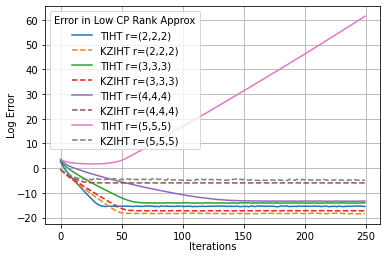

In [170]:
plt.figure()
plt.title("", pad = 30, loc = "center")

plt.plot(range(itr), np.log(data_1[:,0]),  label= "TIHT r=(2,2,2)")
plt.plot(range(itr), np.log(data_1[:,1]),label= "KZIHT r=(2,2,2)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,2]),  label= "TIHT r=(3,3,3)")
plt.plot(range(itr), np.log(data_1[:,3]),label= "KZIHT r=(3,3,3)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,4]),  label= "TIHT r=(4,4,4)")
plt.plot(range(itr), np.log(data_1[:,5]),label= "KZIHT r=(4,4,4)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,6]),  label= "TIHT r=(5,5,5)")
plt.plot(range(itr), np.log(data_1[:,7]),label= "KZIHT r=(5,5,5)",linestyle = '--')

plt.legend(title="Error in Low CP Rank Approx")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Log Error",labelpad = 0)
plt.grid()
plt.savefig('KZIHT VS. TIHT CP.png', dpi=300,  bbox_inches="tight")

In [26]:
###################################
### Recovering Tensors via KZIHT ##
### Random Reshuffling ############
## Low HOSVD Rank #################
###################################

## Considering 10*10*10 tensors
## Errorless Recovery
## Gaussian Measurement Matrices 

cols = []
data = []

itr = 250
num_samples = 50
j = 0

n = 1000
n_dim = [10,10,10]
m = 800

for r in [[4,4,4],[5,5,5],[6,6,6],[7,7,7]]:
    
    avg_err_KZIHT_rr = np.zeros(itr)
    avg_err_KZIHT = np.zeros(itr)
    cols = cols + ['kziht'+str(r[0]), 'kziht_rr'+str(r[0])]
    
    print(r)
        
    for samples in range(num_samples):
        
        #print(samples)
        
        X = random_low_rank_HOSVD(n_dim,r)
        x = vectorize_np(X)

        A = gaussian_mx(m,n)
        b = A@x 
        
        y_KZIHT_rr, error_KZIHT_rr = KZIHT_HOSVD_RR(A,b,X,n,r,gamma = n/m, itr = itr)
        y_KZIHT, error_KZIHT = KZIHT_HOSVD(A,b,X,n,r,gamma = n/m, itr = itr)
        
        avg_err_KZIHT_rr = avg_err_KZIHT_rr + error_KZIHT_rr
        avg_err_KZIHT = avg_err_KZIHT + error_KZIHT
        
    if j == 0:
        
        data = np.concatenate(([avg_err_KZIHT/num_samples],[avg_err_KZIHT_rr/num_samples]), axis = 0).T
        j = j + 1
    
    else:
        
        data = np.concatenate((data, np.array([avg_err_KZIHT/num_samples]).T),axis=1)
        data = np.concatenate((data, np.array([avg_err_KZIHT_rr/num_samples]).T),axis=1) 

data = pd.DataFrame(data, columns = cols)
data.to_csv('/Users/shambhavi/Desktop/Academic/KZ+IHT/Code/sparse_tens_kziht_rr.csv', header = True)

[4, 4, 4]
[5, 5, 5]
[6, 6, 6]
[7, 7, 7]


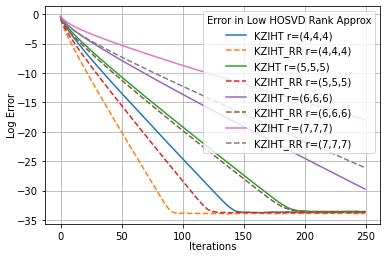

In [34]:
data_1 = np.array(data)
plt.figure()
plt.title("", pad = 30, loc = "center")

plt.plot(range(itr), np.log(data_1[:,0]),label= "KZIHT r=(4,4,4)")
plt.plot(range(itr), np.log(data_1[:,1]),label= "KZIHT_RR r=(4,4,4)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,2]),label= "KZHT r=(5,5,5)")
plt.plot(range(itr), np.log(data_1[:,3]),label= "KZIHT_RR r=(5,5,5)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,4]),label= "KZIHT r=(6,6,6)")
plt.plot(range(itr), np.log(data_1[:,5]),label= "KZIHT_RR r=(6,6,6)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,6]),label= "KZIHT r=(7,7,7)")
plt.plot(range(itr), np.log(data_1[:,7]),label= "KZIHT_RR r=(7,7,7)",linestyle = '--')

plt.legend(title="Error in Low HOSVD Rank Approx")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Log Error",labelpad = 0)
plt.grid()
plt.savefig('KZIHT VS. KZIHT_RR.png', dpi=300,  bbox_inches="tight")

In [38]:
cols = []
data = []

itr = 500
num_samples = 10
j = 0

n = 1000
n_dim = [10,10,10]
m = 800

for r in [[8,8,8],[9,9,9],[10,10,10]]:
    
    avg_err_KZIHT_rr = np.zeros(itr)
    avg_err_KZIHT = np.zeros(itr)
    cols = cols + ['kziht'+str(r[0]), 'kziht_rr'+str(r[0])]
    
    print(r)
        
    for samples in range(num_samples):
        
        #print(samples)
        
        X = random_low_rank_HOSVD(n_dim,r)
        x = vectorize_np(X)

        A = gaussian_mx(m,n)
        b = A@x 
        
        y_KZIHT_rr, error_KZIHT_rr = KZIHT_HOSVD_RR(A,b,X,n,r,gamma = n/m, itr = itr)
        y_KZIHT, error_KZIHT = KZIHT_HOSVD(A,b,X,n,r,gamma = n/m, itr = itr)
        
        avg_err_KZIHT_rr = avg_err_KZIHT_rr + error_KZIHT_rr
        avg_err_KZIHT = avg_err_KZIHT + error_KZIHT
        
    if j == 0:
        
        data = np.concatenate(([avg_err_KZIHT/num_samples],[avg_err_KZIHT_rr/num_samples]), axis = 0).T
        j = j + 1
    
    else:
        
        data = np.concatenate((data, np.array([avg_err_KZIHT/num_samples]).T),axis=1)
        data = np.concatenate((data, np.array([avg_err_KZIHT_rr/num_samples]).T),axis=1) 

data = pd.DataFrame(data, columns = cols)
data.to_csv('/Users/shambhavi/Desktop/Academic/KZ+IHT/Code/sparse_tens_kziht_rr_2.csv', header = True)

[8, 8, 8]
[9, 9, 9]
[10, 10, 10]


In [36]:
np.shape(data)

(250, 4)

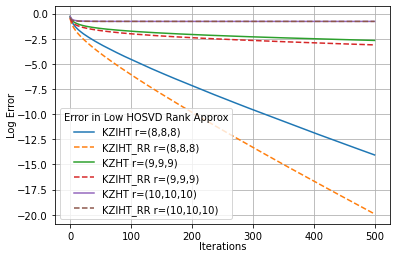

In [39]:
data_1 = np.array(data)
plt.figure()
plt.title("", pad = 30, loc = "center")

plt.plot(range(itr), np.log(data_1[:,0]),label= "KZIHT r=(8,8,8)")
plt.plot(range(itr), np.log(data_1[:,1]),label= "KZIHT_RR r=(8,8,8)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,2]),label= "KZHT r=(9,9,9)")
plt.plot(range(itr), np.log(data_1[:,3]),label= "KZIHT_RR r=(9,9,9)",linestyle = '--')

plt.plot(range(itr), np.log(data_1[:,4]),label= "KZHT r=(10,10,10)")
plt.plot(range(itr), np.log(data_1[:,5]),label= "KZIHT_RR r=(10,10,10)",linestyle = '--')

plt.legend(title="Error in Low HOSVD Rank Approx")
plt.xlabel(xlabel="Iterations",labelpad = 0)
plt.ylabel(ylabel="Log Error",labelpad = 0)
plt.grid()
plt.savefig('KZIHT VS. KZIHT_RR_2.png', dpi=300,  bbox_inches="tight")